In [4]:
# collapse
%load_ext autoreload
%autoreload 1

import sys
sys.path
sys.path.insert(0,'../graspologic')
sys.path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['../graspologic',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/graspologic-0.1.0-py3.6.egg',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/umap_learn-0.5.1-py3.6.egg',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/networkx-2.5-py3.6.egg',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/matplotlib-3.3.0-py3.6-linux-x86_64.egg',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/hyppo-0.1.3-py3.6.egg',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/pynndescent-0.5.2-py3.6.egg',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/numba-0.53.0rc1.post1-py3.6-linux-x86_64.egg',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/llvmlite-0.36.0rc1-py3.6-linux-x86_64.egg',
 '/data/asaadel1/clir_env/lib/python3.6/site-packages/IPython/extensions',
 '/home/asaadel1/.ipython',
 '../graspologic']

# Experiment Summary, n = 150
Let $(G_1, G_2) \sim \rho-SBM(\vec{n},B)$. (NB: binary, symmetric, hollow.)

$K = 3$.

the marginal SBM is conditional on block sizes $\vec{n}=[n_1,n_2,n_3]$.

$B = [(.20,.01,.01);(.01,.10,.01);(.01,.01,.20)]$. (NB: rank($B$)=3 with evalues $\approx [0.212,0.190,0.098]$.)

with $n = 150$ and $\vec{n}=[n_1,n_2,n_3] = [50,50,50]$

for each $\rho \in \{0,0.1,\cdots,0.9,1.0\}$ generate $r$ replicates $(G_1, G_2)$.

For all $r$ replicates, run $GM$ and $GM_{LS}$ (where $GM_{LS}$ uses the "Lightspeed sinkhorn distances" for computing the step direction) each $t$ times, with each $t$ corresponding to a different random permutation on $G_2$ . 

Specifically,$G_2' = Q G_2 Q^T,$ where $Q$ is sampled uniformly from the set of $n x n$ permutations matrices.

For each $t$ permutation, run $GM$ & $GM_{SS}$ from the barycenter ($\gamma = 0$).

For each $r$, the $t$ permutation with the highest associated objective function value will have it's match ratio recorded

For any $\rho$ value, have $\delta$ denote the average match ratio over the $r$ realizations

Plot $x=\rho$ vs $y$= $\delta$ $\pm$ 2s.e.

This notebook contains figures for $r=50$, $t=10$ 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed
import seaborn as sns
# from graspy.match import GraphMatch as GMP
from graspologic.simulations import sbm_corr
# from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

r = 50
t=10
# gmp = GraphMatch('maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True)
def match_ratio(inds, n):
    return np.count_nonzero(inds == np.arange(n)) / n

        
n = 150
m = r
# rhos = 0.1 * np.arange(11)[5:]
rhos = np.arange(8,10.5,0.5) *0.1
n_p = len(rhos)

ratios = np.zeros((n_p,m))
scores = np.zeros((n_p,m))

ratios_ss = np.zeros((n_p,m))
scores_ss = np.zeros((n_p,m))


n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
for k, rho in enumerate(rhos):
    np.random.seed(8888)
    seeds = [np.random.randint(1e8, size=t) for i in range(m)]
    def run_sim(seed):
        
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        score = 0
        res_opt = None

        score_ss = 0
        res_opt_ss = None

        for j in range(t):
            res = quadratic_assignment(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
            if res.fun>score:
                perm = res.col_ind
                score = res.fun

            res_ss = quadratic_assignment_ls(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
            if res_ss.fun>score_ss:
                perm_ss = res_ss.col_ind
                score_ss = res_ss.fun
                
        ratio = match_ratio(perm, n)

        ratio_ss = match_ratio(perm_ss, n)

        return ratio, score, ratio_ss, score_ss

    result = Parallel(n_jobs=-1, verbose=10)(delayed(run_sim)(seed) for seed in seeds)

    ratios[k,:] = [item[0] for item in result]
    scores[k,:] = [item[1] for item in result]
    ratios_ss[k,:] = [item[2] for item in result]
    scores_ss[k,:] = [item[3] for item in result]

In [74]:
from graspologic.simulations import sbm_corr
import time

n = 3000
n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
rho = 0.9
A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )

In [75]:
start = time.time()
res = quadratic_assignment(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
print(res)
print("runtime: ", time.time()-start)
print("match ratio: ", np.mean(res.col_ind == np.arange(int(n/3)*3)))

 col_ind: array([2320, 2634, 2785, ...,  192,  171,  305])
     fun: 145790.0
     nit: 30
runtime:  83.81902694702148
match ratio:  0.0013333333333333333


In [76]:
start = time.time()
res = quadratic_assignment_ls(A1,A2, options={'maximize':True, 'tol':0.0000001,'maxiter':30, 'shuffle_input':True})
print(res)
print("runtime: ", time.time()-start)
print("match ratio: ", np.mean(res.col_ind == np.arange(int(n/3)*3)))

 col_ind: array([ 816,  679,    2, ..., 2997, 2998, 2999])
     fun: 350172.0
     nit: 7
runtime:  105.45533680915833
match ratio:  0.7733333333333333


In [47]:
A = [
        [0, 90, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [90, 0, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0],
        [10, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 0],
        [0, 23, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0],
        [0, 0, 43, 0, 0, 0, 26, 0, 0, 0, 0, 0],
        [0, 0, 0, 88, 0, 0, 0, 16, 0, 0, 0, 0],
        [0, 0, 0, 0, 26, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 16, 0, 0, 0, 96, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 29, 0],
        [0, 0, 0, 0, 0, 0, 0, 96, 0, 0, 0, 37],
        [0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0],
    ]
B = [
        [0, 36, 54, 26, 59, 72, 9, 34, 79, 17, 46, 95],
        [36, 0, 73, 35, 90, 58, 30, 78, 35, 44, 79, 36],
        [54, 73, 0, 21, 10, 97, 58, 66, 69, 61, 54, 63],
        [26, 35, 21, 0, 93, 12, 46, 40, 37, 48, 68, 85],
        [59, 90, 10, 93, 0, 64, 5, 29, 76, 16, 5, 76],
        [72, 58, 97, 12, 64, 0, 96, 55, 38, 54, 0, 34],
        [9, 30, 58, 46, 5, 96, 0, 83, 35, 11, 56, 37],
        [34, 78, 66, 40, 29, 55, 83, 0, 44, 12, 15, 80],
        [79, 35, 69, 37, 76, 38, 35, 44, 0, 64, 39, 33],
        [17, 44, 61, 48, 16, 54, 11, 12, 64, 0, 70, 86],
        [46, 79, 54, 68, 5, 0, 56, 15, 39, 70, 0, 18],
        [95, 36, 63, 85, 76, 34, 37, 80, 33, 86, 18, 0],
    ]
A, B = np.array(A), np.array(B)

quadratic_assignment_ls(A,B, options={'tol':0.00000001,'maxiter':30, 'P0': 'randomized'})

 col_ind: array([ 9,  6,  8,  0, 10,  3,  5,  2, 11,  4,  1,  7])
     fun: 18498
     nit: 19

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed
import seaborn as sns
# from graspy.match import GraphMatch as GMP
from graspologic.simulations import sbm_corr
# from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

r = 25
t=5
# gmp = GraphMatch('maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True)
def match_ratio(inds, n):
    return np.count_nonzero(inds == np.arange(n)) / n

        
n = 1500
m = r
# rhos = 0.1 * np.arange(11)[5:]
rhos = np.arange(8,10.5,0.5) *0.1
n_p = len(rhos)

ratios = np.zeros((n_p,m))
scores = np.zeros((n_p,m))

ratios_ss = np.zeros((n_p,m))
scores_ss = np.zeros((n_p,m))


n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
for k, rho in enumerate(rhos):
    np.random.seed(8888)
    seeds = [np.random.randint(1e8, size=t) for i in range(m)]
    def run_sim(seed):
        
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        score = 0
        res_opt = None

        score_ss = 0
        res_opt_ss = None

        for j in range(t):
            res = quadratic_assignment(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
            if res.fun>score:
                perm = res.col_ind
                score = res.fun

            res_ss = quadratic_assignment_ls(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
            if res_ss.fun>score_ss:
                perm_ss = res_ss.col_ind
                score_ss = res_ss.fun
                
        ratio = match_ratio(perm, n)

        ratio_ss = match_ratio(perm_ss, n)

        return ratio, score, ratio_ss, score_ss

    result = Parallel(n_jobs=-1, verbose=10)(delayed(run_sim)(seed) for seed in seeds)

    ratios[k,:] = [item[0] for item in result]
    scores[k,:] = [item[1] for item in result]
    ratios_ss[k,:] = [item[2] for item in result]
    scores_ss[k,:] = [item[3] for item in result]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:  8.1min remaining: 42.7min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:  8.2min remaining: 21.1min
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed: 10.7min remaining: 16.1min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed: 14.0min remaining: 12.9min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed: 14.8min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed: 15.9min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 17.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 19.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 19.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:  7.6min remaining: 39.9min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | e

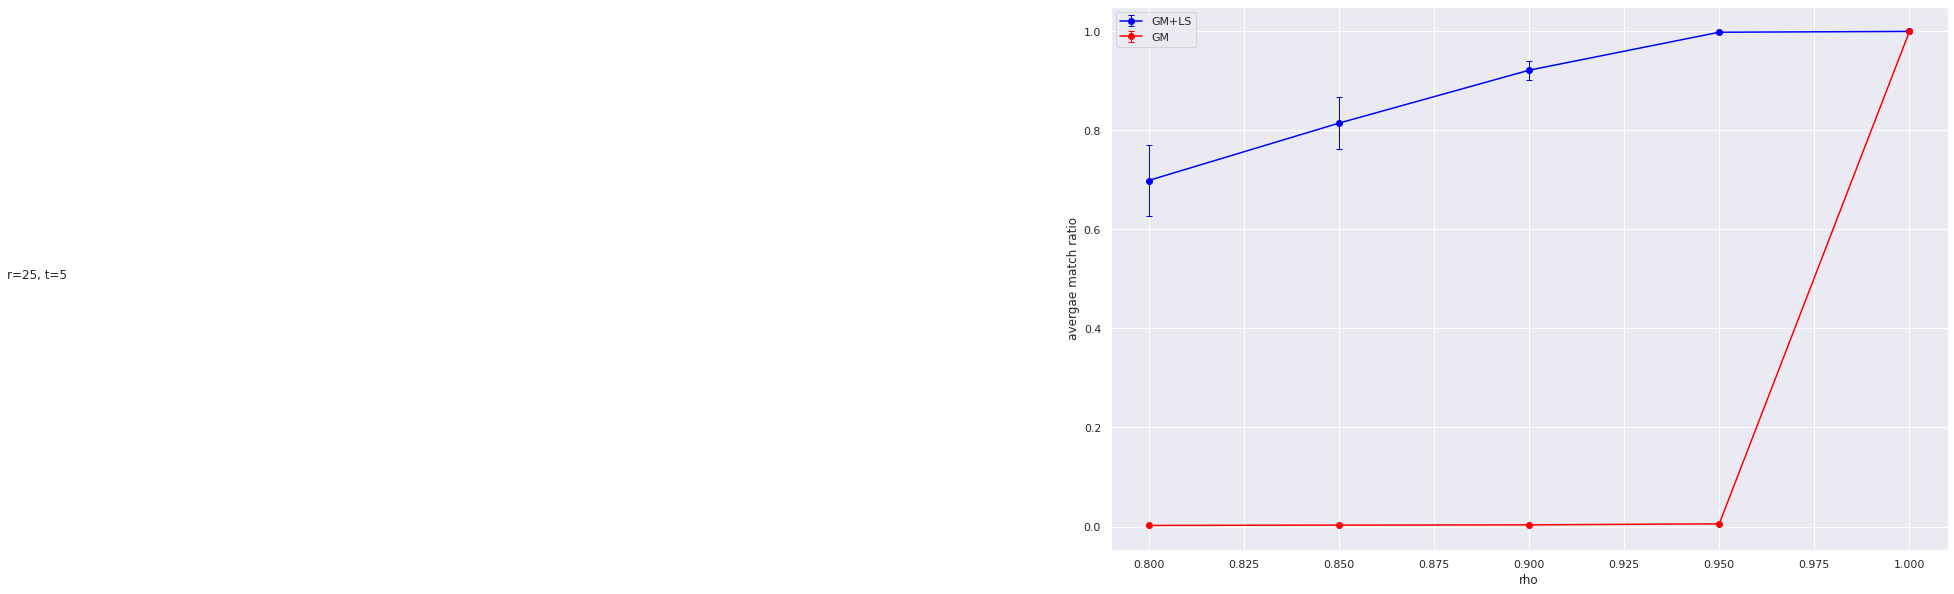

In [87]:
from scipy.stats import sem
error = [sem(ratios[i,:]) for i in range(n_p)]
average = [np.mean(ratios[i,:] ) for i in range(n_p)]

error_ss = [sem(ratios_ss[i,:]) for i in range(n_p)]
average_ss = [np.mean(ratios_ss[i,:] ) for i in range(n_p)]

sns.set_context('poster')
sns.set(rc={'figure.figsize':(15,10)})
txt =f'r={r}, t={t}'
plt.errorbar(rhos,average_ss, error_ss,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+LS', color='blue')
# plt.errorbar(rhos,average_gmlap, error_gmlap,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+dissim(dist)')
plt.errorbar(rhos,average, error,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM', color='red')
# plt.errorbar(rhos,average_lap, error_lap,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='LAP (dist)', color='yellow')
plt.xlabel("rho")
plt.ylabel("avergae match ratio")
plt.text(0.5,0.5,txt)
# plt.title('Gamma = 0')
plt.legend()

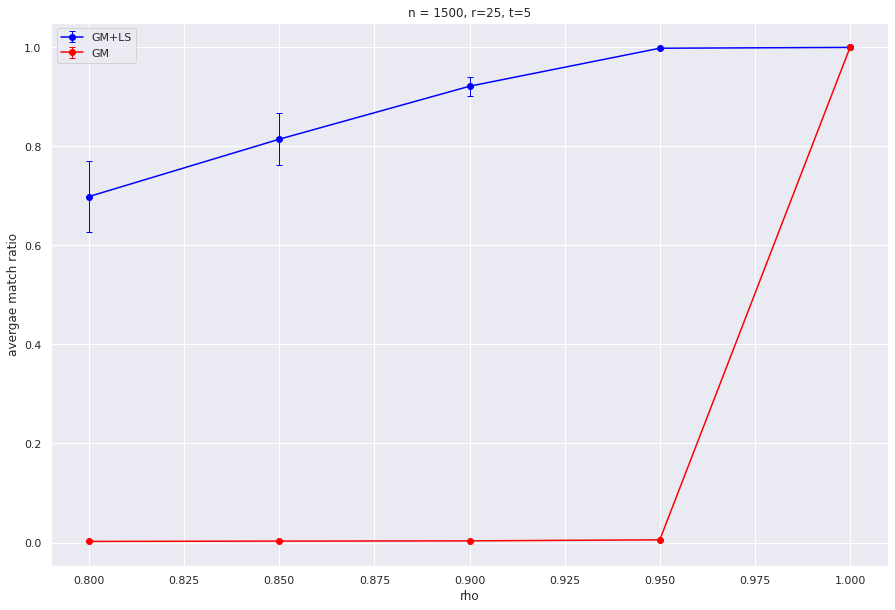

In [93]:
from scipy.stats import sem
error_1500 = [sem(ratios[i,:]) for i in range(n_p)]
average_1500 = [np.mean(ratios[i,:] ) for i in range(n_p)]

error_ss_1500 = [sem(ratios_ss[i,:]) for i in range(n_p)]
average_ss_1500 = [np.mean(ratios_ss[i,:] ) for i in range(n_p)]

sns.set_context('poster')
sns.set(rc={'figure.figsize':(15,10)})
txt =f'r={r}, t={t}'
plt.figure()
plt.errorbar(rhos_1500,average_ss, error_ss,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+LS', color='blue')
# plt.errorbar(rhos,average_gmlap, error_gmlap,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+dissim(dist)')
plt.errorbar(rhos,average, error,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM', color='red')
# plt.errorbar(rhos,average_lap, error_lap,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='LAP (dist)', color='yellow')
plt.xlabel("rho")
plt.ylabel("avergae match ratio")
# plt.text(0.5,0.5,txt)
plt.title(f'n = 1500, {txt}')
plt.legend()

# Vanilla GM

In [41]:
# collapse
import numpy as np
import operator
from scipy.optimize import linear_sum_assignment, OptimizeResult

from scipy._lib._util import check_random_state
import itertools


def quadratic_assignment(A, B, method="faq", options=None):
    r"""
    Approximates solution to the quadratic assignment problem and
    the graph matching problem.
    Quadratic assignment solves problems of the following form:
    .. math::
        \min_P & \ {\ \text{trace}(A^T P B P^T)}\\
        \mbox{s.t. } & {P \ \epsilon \ \mathcal{P}}\\
    where :math:`\mathcal{P}` is the set of all permutation matrices,
    and :math:`A` and :math:`B` are square matrices.
    Graph matching tries to *maximize* the same objective function.
    This algorithm can be thought of as finding the alignment of the
    nodes of two graphs that minimizes the number of induced edge
    disagreements, or, in the case of weighted graphs, the sum of squared
    edge weight differences.
    Note that the quadratic assignment problem is NP-hard, is not
    known to be solvable in polynomial time, and is computationally
    intractable. Therefore, the results given are approximations,
    not guaranteed to be exact solutions.
    Parameters
    ----------
    A : 2d-array, square
        The square matrix :math:`A` in the objective function above.
    B : 2d-array, square
        The square matrix :math:`B` in the objective function above.
    method :  str in {'faq', '2opt'} (default: 'faq')
        The algorithm used to solve the problem.
        :ref:`'faq' <optimize.qap-faq>` (default) and
        :ref:`'2opt' <optimize.qap-2opt>` are available.
    options : dict, optional
        A dictionary of solver options. All solvers support the following:
        partial_match : 2d-array of integers, optional, (default = None)
            Allows the user to fix part of the matching between the two
            matrices. In the literature, a partial match is also
            known as a "seed" [2]_.
            Each row of `partial_match` specifies the indices of a pair of
            corresponding nodes, that is, node ``partial_match[i, 0]`` of `A`
            is matched to node ``partial_match[i, 1]`` of `B`. Accordingly,
            ``partial_match`` is an array of size ``(m , 2)``, where ``m`` is
            not greater than the number of nodes.
        maximize : bool (default = False)
            Setting `maximize` to ``True`` solves the Graph Matching Problem
            (GMP) rather than the Quadratic Assingnment Problem (QAP).
        rng : {None, int, `~np.random.RandomState`, `~np.random.Generator`}
            This parameter defines the object to use for drawing random
            variates.
            If `rng` is ``None`` the `~np.random.RandomState` singleton is
            used.
            If `rng` is an int, a new ``RandomState`` instance is used,
            seeded with `rng`.
            If `rng` is already a ``RandomState`` or ``Generator``
            instance, then that object is used.
            Default is None.
        For method-specific options, see
        :func:`show_options('quadratic_assignment') <show_options>`.
    Returns
    -------
    res : OptimizeResult
        A :class:`scipy.optimize.OptimizeResult` containing the following
        fields.
        col_ind : 1-D array
            An array of column indices corresponding with the best
            permutation of the nodes of `B` found.
        fun : float
            The corresponding value of the objective function.
        nit : int
            The number of iterations performed during optimization.
    Notes
    -----
    The default method :ref:`'faq' <optimize.qap-faq>` uses the Fast
    Approximate QAP algorithm [1]_; it is typically offers the best
    combination of speed and accuracy.
    Method :ref:`'2opt' <optimize.qap-2opt>` can be computationally expensive,
    but may be a useful alternative, or it can be used to refine the solution
    returned by another method.
    References
    ----------
    .. [1] J.T. Vogelstein, J.M. Conroy, V. Lyzinski, L.J. Podrazik,
           S.G. Kratzer, E.T. Harley, D.E. Fishkind, R.J. Vogelstein, and
           C.E. Priebe, "Fast approximate quadratic programming for graph
           matching," PLOS one, vol. 10, no. 4, p. e0121002, 2015,
           :doi:`10.1371/journal.pone.0121002`
    .. [2] D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski,
           C. Priebe, "Seeded graph matching", Pattern Recognit. 87 (2019):
           203-215, :doi:`10.1016/j.patcog.2018.09.014`
    .. [3] "2-opt," Wikipedia.
           https://en.wikipedia.org/wiki/2-opt
    Examples
    --------
    >>> import numpy as np
    >>> from scipy.optimize import quadratic_assignment
    >>> A = np.array([[0, 80, 150, 170], [80, 0, 130, 100],
    ...              [150, 130, 0, 120], [170, 100, 120, 0]])
    >>> B = np.array([[0, 5, 2, 7], [0, 0, 3, 8],
    ...              [0, 0, 0, 3], [0, 0, 0, 0]])
    >>> res = quadratic_assignment(A, B)
    >>> print(res)
     col_ind: array([0, 3, 2, 1])
         fun: 3260
         nit: 9
    The see the relationship between the returned ``col_ind`` and ``fun``,
    use ``col_ind`` to form the best permutation matrix found, then evaluate
    the objective function :math:`f(P) = trace(A^T P B P^T )`.
    >>> n = A.shape[0]
    >>> perm = res['col_ind']
    >>> P = np.eye(n, dtype=int)[perm]
    >>> fun = np.trace(A.T @ P @ B @ P.T)
    >>> print(fun)
    3260
    Alternatively, to avoid constructing the permutation matrix explicitly,
    directly permute the rows and columns of the distance matrix.
    >>> fun = np.trace(A.T @ B[perm][:, perm])
    >>> print(fun)
    3260
    Although not guaranteed in general, ``quadratic_assignment`` happens to
    have found the globally optimal solution.
    >>> from itertools import permutations
    >>> perm_opt, fun_opt = None, np.inf
    >>> for perm in permutations([0, 1, 2, 3]):
    ...     perm = np.array(perm)
    ...     fun = np.trace(A.T @ B[perm][:, perm])
    ...     if fun < fun_opt:
    ...         fun_opt, perm_opt = fun, perm
    >>> print(np.array_equal(perm_opt, res['col_ind']))
    True
    Here is an example for which the default method,
    :ref:`'faq' <optimize.qap-faq>`, does not find the global optimum.
    >>> A = np.array([[0, 5, 8, 6], [5, 0, 5, 1],
    ...              [8, 5, 0, 2], [6, 1, 2, 0]])
    >>> B = np.array([[0, 1, 8, 4], [1, 0, 5, 2],
    ...              [8, 5, 0, 5], [4, 2, 5, 0]])
    >>> res = quadratic_assignment(A, B)
    >>> print(res)
     col_ind: array([1, 0, 3, 2])
         fun: 178
         nit: 13
    If accuracy is important, consider using  :ref:`'2opt' <optimize.qap-2opt>`
    to refine the solution.
    >>> guess = np.array([np.arange(A.shape[0]), res.col_ind]).T
    >>> res = quadratic_assignment(A, B, method="2opt",
    ...                            options = {'partial_guess': guess})
    >>> print(res)
     col_ind: array([1, 2, 3, 0])
         fun: 176
         nit: 17
    """

    if options is None:
        options = {}

    method = method.lower()
    methods = {"faq": _quadratic_assignment_faq}
    if method not in methods:
        raise ValueError(f"method {method} must be in {methods}.")
    res = methods[method](A, B, **options)
    return res


def _calc_score(A, B, perm):
    # equivalent to objective function but avoids matmul
    return np.sum(A * B[perm][:, perm])


def _common_input_validation(A, B, partial_match):
    A = np.atleast_2d(A)
    B = np.atleast_2d(B)

    if partial_match is None:
        partial_match = np.array([[], []]).T
    partial_match = np.atleast_2d(partial_match).astype(int)

    msg = None
    if A.shape[0] != A.shape[1]:
        msg = "`A` must be square"
    elif B.shape[0] != B.shape[1]:
        msg = "`B` must be square"
    elif A.ndim != 2 or B.ndim != 2:
        msg = "`A` and `B` must have exactly two dimensions"
    elif A.shape != B.shape:
        msg = "`A` and `B` matrices must be of equal size"
    elif partial_match.shape[0] > A.shape[0]:
        msg = "`partial_match` can have only as many seeds as there are nodes"
    elif partial_match.shape[1] != 2:
        msg = "`partial_match` must have two columns"
    elif partial_match.ndim != 2:
        msg = "`partial_match` must have exactly two dimensions"
    elif (partial_match < 0).any():
        msg = "`partial_match` must contain only positive indices"
    elif (partial_match >= len(A)).any():
        msg = "`partial_match` entries must be less than number of nodes"
    elif not len(set(partial_match[:, 0])) == len(partial_match[:, 0]) or not len(
        set(partial_match[:, 1])
    ) == len(partial_match[:, 1]):
        msg = "`partial_match` column entries must be unique"

    if msg is not None:
        raise ValueError(msg)

    return A, B, partial_match


def _quadratic_assignment_faq(
    A,
    B,
    maximize=False,
    partial_match=None,
    rng=None,
    P0="barycenter",
    shuffle_input=False,
    maxiter=30,
    tol=0.03,
):
    r"""
    Solve the quadratic assignment problem (approximately).
    This function solves the Quadratic Assignment Problem (QAP) and the
    Graph Matching Problem (GMP) using the Fast Approximate QAP Algorithm
    (FAQ) [1]_.
    Quadratic assignment solves problems of the following form:
    .. math::
        \min_P & \ {\ \text{trace}(A^T P B P^T)}\\
        \mbox{s.t. } & {P \ \epsilon \ \mathcal{P}}\\
    where :math:`\mathcal{P}` is the set of all permutation matrices,
    and :math:`A` and :math:`B` are square matrices.
    Graph matching tries to *maximize* the same objective function.
    This algorithm can be thought of as finding the alignment of the
    nodes of two graphs that minimizes the number of induced edge
    disagreements, or, in the case of weighted graphs, the sum of squared
    edge weight differences.
    Note that the quadratic assignment problem is NP-hard, is not
    known to be solvable in polynomial time, and is computationally
    intractable. Therefore, the results given are approximations,
    not guaranteed to be exact solutions.
    Parameters
    ----------
    A : 2d-array, square
        The square matrix :math:`A` in the objective function above.
    B : 2d-array, square
        The square matrix :math:`B` in the objective function above.
    method :  str in {'faq', '2opt'} (default: 'faq')
        The algorithm used to solve the problem. This is the method-specific
        documentation for 'faq'.
        :ref:`'2opt' <optimize.qap-2opt>` is also available.
    Options
    -------
    maximize : bool (default = False)
        Setting `maximize` to ``True`` solves the Graph Matching Problem (GMP)
        rather than the Quadratic Assingnment Problem (QAP). This is
        accomplished through trivial negation of the objective function.
    rng : {None, int, `~np.random.RandomState`, `~np.random.Generator`}
        This parameter defines the object to use for drawing random
        variates.
        If `rng` is ``None`` the `~np.random.RandomState` singleton is
        used.
        If `rng` is an int, a new ``RandomState`` instance is used,
        seeded with `rng`.
        If `rng` is already a ``RandomState`` or ``Generator``
        instance, then that object is used.
        Default is None.
    partial_match : 2d-array of integers, optional, (default = None)
        Allows the user to fix part of the matching between the two
        matrices. In the literature, a partial match is also known as a
        "seed".
        Each row of `partial_match` specifies the indices of a pair of
        corresponding nodes, that is, node ``partial_match[i, 0]`` of `A` is
        matched to node ``partial_match[i, 1]`` of `B`. Accordingly,
        ``partial_match`` is an array of size ``(m , 2)``, where ``m`` is
        not greater than the number of nodes, :math:`n`.
    P0 : 2d-array, "barycenter", or "randomized" (default = "barycenter")
        The initial (guess) permutation matrix or search "position"
        `P0`.
        `P0` need not be a proper permutation matrix;
        however, it must be :math:`m' x m'`, where :math:`m' = n - m`,
        and it must be doubly stochastic: each of its rows and columns must
        sum to 1.
        If unspecified or ``"barycenter"``, the non-informative "flat
        doubly stochastic matrix" :math:`J = 1*1^T/m'`, where :math:`1` is
        a :math:`m' \times 1` array of ones, is used. This is the "barycenter"
        of the search space of doubly-stochastic matrices.
        If ``"randomized"``, the algorithm will start from the
        randomized initial search position :math:`P_0 = (J + K)/2`,
        where :math:`J` is the "barycenter" and :math:`K` is a random
        doubly stochastic matrix.
    shuffle_input : bool (default = False)
        To avoid artificially high or low matching due to inherent
        sorting of input matrices, gives users the option
        to shuffle the nodes. Results are then unshuffled so that the
        returned results correspond with the node order of inputs.
        Shuffling may cause the algorithm to be non-deterministic,
        unless a random seed is set or an `rng` option is provided.
    maxiter : int, positive (default = 30)
        Integer specifying the max number of Franke-Wolfe iterations performed.
    tol : float (default = 0.03)
        A threshold for the stopping criterion. Franke-Wolfe
        iteration terminates when the change in search position between
        iterations is sufficiently small, that is, when the relative Frobenius
        norm, :math:`\frac{||P_{i}-P_{i+1}||_F}{\sqrt{len(P_{i})}} \leq tol`,
        where :math:`i` is the iteration number.
    Returns
    -------
    res : OptimizeResult
        A :class:`scipy.optimize.OptimizeResult` containing the following
        fields.
        col_ind : 1-D array
            An array of column indices corresponding with the best
            permutation of the nodes of `B` found.
        fun : float
            The corresponding value of the objective function.
        nit : int
            The number of Franke-Wolfe iterations performed.
    Notes
    -----
    The algorithm may be sensitive to the initial permutation matrix (or
    search "position") due to the possibility of several local minima
    within the feasible region. A barycenter initialization is more likely to
    result in a better solution than a single random initialization. However,
    ``quadratic_assignment`` calling several times with different random
    initializations may result in a better optimum at the cost of longer
    total execution time.
    Examples
    --------
    As mentioned above, a barycenter initialization often results in a better
    solution than a single random initialization.
    >>> np.random.seed(0)
    >>> n = 15
    >>> A = np.random.rand(n, n)
    >>> B = np.random.rand(n, n)
    >>> res = quadratic_assignment(A, B)  # FAQ is default method
    >>> print(res.fun)
    46.871483385480545 # may vary
    >>> options = {"P0": "randomized"}  # use randomized initialization
    >>> res = quadratic_assignment(A, B, options=options)
    >>> print(res.fun)
    47.224831071310625 # may vary
    However, consider running from several randomized initializations and
    keeping the best result.
    >>> res = min([quadratic_assignment(A, B, options=options)
    ...            for i in range(30)], key=lambda x: x.fun)
    >>> print(res.fun)
    46.671852533681516 # may vary
    The '2-opt' method can be used to further refine the results.
    >>> options = {"partial_guess": np.array([np.arange(n), res.col_ind]).T}
    >>> res = quadratic_assignment(A, B, method="2opt", options=options)
    >>> print(res.fun)
    46.47160735721583 # may vary
    References
    ----------
    .. [1] J.T. Vogelstein, J.M. Conroy, V. Lyzinski, L.J. Podrazik,
           S.G. Kratzer, E.T. Harley, D.E. Fishkind, R.J. Vogelstein, and
           C.E. Priebe, "Fast approximate quadratic programming for graph
           matching," PLOS one, vol. 10, no. 4, p. e0121002, 2015,
           :doi:`10.1371/journal.pone.0121002`
    .. [2] D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski,
           C. Priebe, "Seeded graph matching", Pattern Recognit. 87 (2019):
           203-215, :doi:`10.1016/j.patcog.2018.09.014`
    """

    maxiter = operator.index(maxiter)

    # ValueError check
    A, B, partial_match = _common_input_validation(A, B, partial_match)

    msg = None
    if isinstance(P0, str) and P0 not in {"barycenter", "randomized"}:
        msg = "Invalid 'P0' parameter string"
    elif maxiter <= 0:
        msg = "'maxiter' must be a positive integer"
    elif tol <= 0:
        msg = "'tol' must be a positive float"
    if msg is not None:
        raise ValueError(msg)

    rng = check_random_state(rng)
    n = A.shape[0]  # number of vertices in graphs
    n_seeds = partial_match.shape[0]  # number of seeds
    n_unseed = n - n_seeds

    # check outlier cases
    if n == 0 or partial_match.shape[0] == n:
        score = _calc_score(A, B, partial_match[:, 1])
        res = {"col_ind": partial_match[:, 1], "fun": score, "nit": 0}
        return OptimizeResult(res)

    obj_func_scalar = 1
    if maximize:
        obj_func_scalar = -1

    nonseed_B = np.setdiff1d(range(n), partial_match[:, 1])
    if shuffle_input:
        nonseed_B = rng.permutation(nonseed_B)
        # shuffle_input to avoid results from inputs that were already matched

    nonseed_A = np.setdiff1d(range(n), partial_match[:, 0])
    perm_A = np.concatenate([partial_match[:, 0], nonseed_A])
    perm_B = np.concatenate([partial_match[:, 1], nonseed_B])

    # definitions according to Seeded Graph Matching [2].
    A11, A12, A21, A22 = _split_matrix(A[perm_A][:, perm_A], n_seeds)
    B11, B12, B21, B22 = _split_matrix(B[perm_B][:, perm_B], n_seeds)

    # [1] Algorithm 1 Line 1 - choose initialization
    if isinstance(P0, str):
        # initialize J, a doubly stochastic barycenter
        J = np.ones((n_unseed, n_unseed)) / n_unseed
        if P0 == "barycenter":
            P = J
        elif P0 == "randomized":
            # generate a nxn matrix where each entry is a random number [0, 1]
            # would use rand, but Generators don't have it
            # would use random, but old mtrand.RandomStates don't have it
            K = rng.uniform(size=(n_unseed, n_unseed))
            # Sinkhorn balancing
            K = _doubly_stochastic(K)
            P = J * 0.5 + K * 0.5
    else:
        P0 = np.atleast_2d(P0)
        _check_init_input(P0, n_unseed)
        P = P0

    const_sum = A21 @ B21.T + A12.T @ B12

    # [1] Algorithm 1 Line 2 - loop while stopping criteria not met
    for n_iter in range(1, maxiter + 1):
        # [1] Algorithm 1 Line 3 - compute the gradient of f(P) = -tr(APB^tP^t)
        grad_fp = const_sum + A22 @ P @ B22.T + A22.T @ P @ B22
        # [1] Algorithm 1 Line 4 - get direction Q by solving Eq. 8
        _, cols = linear_sum_assignment(grad_fp, maximize=maximize)
        Q = np.eye(n_unseed)[cols]

        # [1] Algorithm 1 Line 5 - compute the step size
        # Noting that e.g. trace(Ax) = trace(A)*x, expand and re-collect
        # terms as ax**2 + bx + c. c does not affect location of minimum
        # and can be ignored. Also, note that trace(A@B) = (A.T*B).sum();
        # apply where possible for efficiency.
        R = P - Q
        b21 = ((R.T @ A21) * B21).sum()
        b12 = ((R.T @ A12.T) * B12.T).sum()
        AR22 = A22.T @ R
        BR22 = B22 @ R.T
        b22a = (AR22 * B22.T[cols]).sum()
        b22b = (A22 * BR22[cols]).sum()
        a = (AR22.T * BR22).sum()
        b = b21 + b12 + b22a + b22b
        # critical point of ax^2 + bx + c is at x = -d/(2*e)
        # if a * obj_func_scalar > 0, it is a minimum
        # if minimum is not in [0, 1], only endpoints need to be considered
        if a * obj_func_scalar > 0 and 0 <= -b / (2 * a) <= 1:
            alpha = -b / (2 * a)
        else:
            alpha = np.argmin([0, (b + a) * obj_func_scalar])

        # [1] Algorithm 1 Line 6 - Update P
        P_i1 = alpha * P + (1 - alpha) * Q
        if np.linalg.norm(P - P_i1) / np.sqrt(n_unseed) < tol:
            P = P_i1
            break
        P = P_i1
    # [1] Algorithm 1 Line 7 - end main loop

    # [1] Algorithm 1 Line 8 - project onto the set of permutation matrices
    _, col = linear_sum_assignment(-P)
    perm = np.concatenate((np.arange(n_seeds), col + n_seeds))

    unshuffled_perm = np.zeros(n, dtype=int)
    unshuffled_perm[perm_A] = perm_B[perm]

    score = _calc_score(A, B, unshuffled_perm)

    res = {"col_ind": unshuffled_perm, "fun": score, "nit": n_iter}

    return OptimizeResult(res)


def _check_init_input(P0, n):
    row_sum = np.sum(P0, axis=0)
    col_sum = np.sum(P0, axis=1)
    tol = 1e-3
    msg = None
    if P0.shape != (n, n):
        msg = "`P0` matrix must have shape m' x m', where m'=n-m"
    elif (
        (~np.isclose(row_sum, 1, atol=tol)).any()
        or (~np.isclose(col_sum, 1, atol=tol)).any()
        or (P0 < 0).any()
    ):
        msg = "`P0` matrix must be doubly stochastic"
    if msg is not None:
        raise ValueError(msg)


def _split_matrix(X, n):
    # definitions according to Seeded Graph Matching [2].
    upper, lower = X[:n], X[n:]
    return upper[:, :n], upper[:, n:], lower[:, :n], lower[:, n:]


def _doubly_stochastic(P, tol=1e-3):
    # Adapted from @btaba implementation
    # https://github.com/btaba/sinkhorn_knopp
    # of Sinkhorn-Knopp algorithm
    # https://projecteuclid.org/euclid.pjm/1102992505

    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if (np.abs(P_eps.sum(axis=1) - 1) < tol).all() and (
            np.abs(P_eps.sum(axis=0) - 1) < tol
        ).all():
            # All column/row sums ~= 1 within threshold
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c

    return P_eps


# GM + LightSpeedLAP

In [60]:
# collapse
import numpy as np
import operator
from scipy.optimize import linear_sum_assignment, OptimizeResult

from scipy._lib._util import check_random_state
import itertools
from ot import sinkhorn


def quadratic_assignment_ls(A, B, method="faq", options=None):
    r"""
    Approximates solution to the quadratic assignment problem and
    the graph matching problem.
    Quadratic assignment solves problems of the following form:
    .. math::
        \min_P & \ {\ \text{trace}(A^T P B P^T)}\\
        \mbox{s.t. } & {P \ \epsilon \ \mathcal{P}}\\
    where :math:`\mathcal{P}` is the set of all permutation matrices,
    and :math:`A` and :math:`B` are square matrices.
    Graph matching tries to *maximize* the same objective function.
    This algorithm can be thought of as finding the alignment of the
    nodes of two graphs that minimizes the number of induced edge
    disagreements, or, in the case of weighted graphs, the sum of squared
    edge weight differences.
    Note that the quadratic assignment problem is NP-hard, is not
    known to be solvable in polynomial time, and is computationally
    intractable. Therefore, the results given are approximations,
    not guaranteed to be exact solutions.
    Parameters
    ----------
    A : 2d-array, square
        The square matrix :math:`A` in the objective function above.
    B : 2d-array, square
        The square matrix :math:`B` in the objective function above.
    method :  str in {'faq', '2opt'} (default: 'faq')
        The algorithm used to solve the problem.
        :ref:`'faq' <optimize.qap-faq>` (default) and
        :ref:`'2opt' <optimize.qap-2opt>` are available.
    options : dict, optional
        A dictionary of solver options. All solvers support the following:
        partial_match : 2d-array of integers, optional, (default = None)
            Allows the user to fix part of the matching between the two
            matrices. In the literature, a partial match is also
            known as a "seed" [2]_.
            Each row of `partial_match` specifies the indices of a pair of
            corresponding nodes, that is, node ``partial_match[i, 0]`` of `A`
            is matched to node ``partial_match[i, 1]`` of `B`. Accordingly,
            ``partial_match`` is an array of size ``(m , 2)``, where ``m`` is
            not greater than the number of nodes.
        maximize : bool (default = False)
            Setting `maximize` to ``True`` solves the Graph Matching Problem
            (GMP) rather than the Quadratic Assingnment Problem (QAP).
        rng : {None, int, `~np.random.RandomState`, `~np.random.Generator`}
            This parameter defines the object to use for drawing random
            variates.
            If `rng` is ``None`` the `~np.random.RandomState` singleton is
            used.
            If `rng` is an int, a new ``RandomState`` instance is used,
            seeded with `rng`.
            If `rng` is already a ``RandomState`` or ``Generator``
            instance, then that object is used.
            Default is None.
        For method-specific options, see
        :func:`show_options('quadratic_assignment') <show_options>`.
    Returns
    -------
    res : OptimizeResult
        A :class:`scipy.optimize.OptimizeResult` containing the following
        fields.
        col_ind : 1-D array
            An array of column indices corresponding with the best
            permutation of the nodes of `B` found.
        fun : float
            The corresponding value of the objective function.
        nit : int
            The number of iterations performed during optimization.
    Notes
    -----
    The default method :ref:`'faq' <optimize.qap-faq>` uses the Fast
    Approximate QAP algorithm [1]_; it is typically offers the best
    combination of speed and accuracy.
    Method :ref:`'2opt' <optimize.qap-2opt>` can be computationally expensive,
    but may be a useful alternative, or it can be used to refine the solution
    returned by another method.
    References
    ----------
    .. [1] J.T. Vogelstein, J.M. Conroy, V. Lyzinski, L.J. Podrazik,
           S.G. Kratzer, E.T. Harley, D.E. Fishkind, R.J. Vogelstein, and
           C.E. Priebe, "Fast approximate quadratic programming for graph
           matching," PLOS one, vol. 10, no. 4, p. e0121002, 2015,
           :doi:`10.1371/journal.pone.0121002`
    .. [2] D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski,
           C. Priebe, "Seeded graph matching", Pattern Recognit. 87 (2019):
           203-215, :doi:`10.1016/j.patcog.2018.09.014`
    .. [3] "2-opt," Wikipedia.
           https://en.wikipedia.org/wiki/2-opt
    Examples
    --------
    >>> import numpy as np
    >>> from scipy.optimize import quadratic_assignment
    >>> A = np.array([[0, 80, 150, 170], [80, 0, 130, 100],
    ...              [150, 130, 0, 120], [170, 100, 120, 0]])
    >>> B = np.array([[0, 5, 2, 7], [0, 0, 3, 8],
    ...              [0, 0, 0, 3], [0, 0, 0, 0]])
    >>> res = quadratic_assignment(A, B)
    >>> print(res)
     col_ind: array([0, 3, 2, 1])
         fun: 3260
         nit: 9
    The see the relationship between the returned ``col_ind`` and ``fun``,
    use ``col_ind`` to form the best permutation matrix found, then evaluate
    the objective function :math:`f(P) = trace(A^T P B P^T )`.
    >>> n = A.shape[0]
    >>> perm = res['col_ind']
    >>> P = np.eye(n, dtype=int)[perm]
    >>> fun = np.trace(A.T @ P @ B @ P.T)
    >>> print(fun)
    3260
    Alternatively, to avoid constructing the permutation matrix explicitly,
    directly permute the rows and columns of the distance matrix.
    >>> fun = np.trace(A.T @ B[perm][:, perm])
    >>> print(fun)
    3260
    Although not guaranteed in general, ``quadratic_assignment`` happens to
    have found the globally optimal solution.
    >>> from itertools import permutations
    >>> perm_opt, fun_opt = None, np.inf
    >>> for perm in permutations([0, 1, 2, 3]):
    ...     perm = np.array(perm)
    ...     fun = np.trace(A.T @ B[perm][:, perm])
    ...     if fun < fun_opt:
    ...         fun_opt, perm_opt = fun, perm
    >>> print(np.array_equal(perm_opt, res['col_ind']))
    True
    Here is an example for which the default method,
    :ref:`'faq' <optimize.qap-faq>`, does not find the global optimum.
    >>> A = np.array([[0, 5, 8, 6], [5, 0, 5, 1],
    ...              [8, 5, 0, 2], [6, 1, 2, 0]])
    >>> B = np.array([[0, 1, 8, 4], [1, 0, 5, 2],
    ...              [8, 5, 0, 5], [4, 2, 5, 0]])
    >>> res = quadratic_assignment(A, B)
    >>> print(res)
     col_ind: array([1, 0, 3, 2])
         fun: 178
         nit: 13
    If accuracy is important, consider using  :ref:`'2opt' <optimize.qap-2opt>`
    to refine the solution.
    >>> guess = np.array([np.arange(A.shape[0]), res.col_ind]).T
    >>> res = quadratic_assignment(A, B, method="2opt",
    ...                            options = {'partial_guess': guess})
    >>> print(res)
     col_ind: array([1, 2, 3, 0])
         fun: 176
         nit: 17
    """

    if options is None:
        options = {}

    method = method.lower()
    methods = {"faq": _quadratic_assignment_faq_ls}
    if method not in methods:
        raise ValueError(f"method {method} must be in {methods}.")
    res = methods[method](A, B, **options)
    return res


def _calc_score(A, B, perm):
    # equivalent to objective function but avoids matmul
    return np.sum(A * B[perm][:, perm])


def _common_input_validation(A, B, partial_match):
    A = np.atleast_2d(A)
    B = np.atleast_2d(B)

    if partial_match is None:
        partial_match = np.array([[], []]).T
    partial_match = np.atleast_2d(partial_match).astype(int)

    msg = None
    if A.shape[0] != A.shape[1]:
        msg = "`A` must be square"
    elif B.shape[0] != B.shape[1]:
        msg = "`B` must be square"
    elif A.ndim != 2 or B.ndim != 2:
        msg = "`A` and `B` must have exactly two dimensions"
    elif A.shape != B.shape:
        msg = "`A` and `B` matrices must be of equal size"
    elif partial_match.shape[0] > A.shape[0]:
        msg = "`partial_match` can have only as many seeds as there are nodes"
    elif partial_match.shape[1] != 2:
        msg = "`partial_match` must have two columns"
    elif partial_match.ndim != 2:
        msg = "`partial_match` must have exactly two dimensions"
    elif (partial_match < 0).any():
        msg = "`partial_match` must contain only positive indices"
    elif (partial_match >= len(A)).any():
        msg = "`partial_match` entries must be less than number of nodes"
    elif not len(set(partial_match[:, 0])) == len(partial_match[:, 0]) or not len(
        set(partial_match[:, 1])
    ) == len(partial_match[:, 1]):
        msg = "`partial_match` column entries must be unique"

    if msg is not None:
        raise ValueError(msg)

    return A, B, partial_match


def _quadratic_assignment_faq_ls(
    A,
    B,
    maximize=False,
    partial_match=None,
    rng=None,
    P0="barycenter",
    shuffle_input=False,
    maxiter=30,
    tol=0.03,
):
    r"""
    Solve the quadratic assignment problem (approximately).
    This function solves the Quadratic Assignment Problem (QAP) and the
    Graph Matching Problem (GMP) using the Fast Approximate QAP Algorithm
    (FAQ) [1]_.
    Quadratic assignment solves problems of the following form:
    .. math::
        \min_P & \ {\ \text{trace}(A^T P B P^T)}\\
        \mbox{s.t. } & {P \ \epsilon \ \mathcal{P}}\\
    where :math:`\mathcal{P}` is the set of all permutation matrices,
    and :math:`A` and :math:`B` are square matrices.
    Graph matching tries to *maximize* the same objective function.
    This algorithm can be thought of as finding the alignment of the
    nodes of two graphs that minimizes the number of induced edge
    disagreements, or, in the case of weighted graphs, the sum of squared
    edge weight differences.
    Note that the quadratic assignment problem is NP-hard, is not
    known to be solvable in polynomial time, and is computationally
    intractable. Therefore, the results given are approximations,
    not guaranteed to be exact solutions.
    Parameters
    ----------
    A : 2d-array, square
        The square matrix :math:`A` in the objective function above.
    B : 2d-array, square
        The square matrix :math:`B` in the objective function above.
    method :  str in {'faq', '2opt'} (default: 'faq')
        The algorithm used to solve the problem. This is the method-specific
        documentation for 'faq'.
        :ref:`'2opt' <optimize.qap-2opt>` is also available.
    Options
    -------
    maximize : bool (default = False)
        Setting `maximize` to ``True`` solves the Graph Matching Problem (GMP)
        rather than the Quadratic Assingnment Problem (QAP). This is
        accomplished through trivial negation of the objective function.
    rng : {None, int, `~np.random.RandomState`, `~np.random.Generator`}
        This parameter defines the object to use for drawing random
        variates.
        If `rng` is ``None`` the `~np.random.RandomState` singleton is
        used.
        If `rng` is an int, a new ``RandomState`` instance is used,
        seeded with `rng`.
        If `rng` is already a ``RandomState`` or ``Generator``
        instance, then that object is used.
        Default is None.
    partial_match : 2d-array of integers, optional, (default = None)
        Allows the user to fix part of the matching between the two
        matrices. In the literature, a partial match is also known as a
        "seed".
        Each row of `partial_match` specifies the indices of a pair of
        corresponding nodes, that is, node ``partial_match[i, 0]`` of `A` is
        matched to node ``partial_match[i, 1]`` of `B`. Accordingly,
        ``partial_match`` is an array of size ``(m , 2)``, where ``m`` is
        not greater than the number of nodes, :math:`n`.
    P0 : 2d-array, "barycenter", or "randomized" (default = "barycenter")
        The initial (guess) permutation matrix or search "position"
        `P0`.
        `P0` need not be a proper permutation matrix;
        however, it must be :math:`m' x m'`, where :math:`m' = n - m`,
        and it must be doubly stochastic: each of its rows and columns must
        sum to 1.
        If unspecified or ``"barycenter"``, the non-informative "flat
        doubly stochastic matrix" :math:`J = 1*1^T/m'`, where :math:`1` is
        a :math:`m' \times 1` array of ones, is used. This is the "barycenter"
        of the search space of doubly-stochastic matrices.
        If ``"randomized"``, the algorithm will start from the
        randomized initial search position :math:`P_0 = (J + K)/2`,
        where :math:`J` is the "barycenter" and :math:`K` is a random
        doubly stochastic matrix.
    shuffle_input : bool (default = False)
        To avoid artificially high or low matching due to inherent
        sorting of input matrices, gives users the option
        to shuffle the nodes. Results are then unshuffled so that the
        returned results correspond with the node order of inputs.
        Shuffling may cause the algorithm to be non-deterministic,
        unless a random seed is set or an `rng` option is provided.
    maxiter : int, positive (default = 30)
        Integer specifying the max number of Franke-Wolfe iterations performed.
    tol : float (default = 0.03)
        A threshold for the stopping criterion. Franke-Wolfe
        iteration terminates when the change in search position between
        iterations is sufficiently small, that is, when the relative Frobenius
        norm, :math:`\frac{||P_{i}-P_{i+1}||_F}{\sqrt{len(P_{i})}} \leq tol`,
        where :math:`i` is the iteration number.
    Returns
    -------
    res : OptimizeResult
        A :class:`scipy.optimize.OptimizeResult` containing the following
        fields.
        col_ind : 1-D array
            An array of column indices corresponding with the best
            permutation of the nodes of `B` found.
        fun : float
            The corresponding value of the objective function.
        nit : int
            The number of Franke-Wolfe iterations performed.
    Notes
    -----
    The algorithm may be sensitive to the initial permutation matrix (or
    search "position") due to the possibility of several local minima
    within the feasible region. A barycenter initialization is more likely to
    result in a better solution than a single random initialization. However,
    ``quadratic_assignment`` calling several times with different random
    initializations may result in a better optimum at the cost of longer
    total execution time.
    Examples
    --------
    As mentioned above, a barycenter initialization often results in a better
    solution than a single random initialization.
    >>> np.random.seed(0)
    >>> n = 15
    >>> A = np.random.rand(n, n)
    >>> B = np.random.rand(n, n)
    >>> res = quadratic_assignment(A, B)  # FAQ is default method
    >>> print(res.fun)
    46.871483385480545 # may vary
    >>> options = {"P0": "randomized"}  # use randomized initialization
    >>> res = quadratic_assignment(A, B, options=options)
    >>> print(res.fun)
    47.224831071310625 # may vary
    However, consider running from several randomized initializations and
    keeping the best result.
    >>> res = min([quadratic_assignment(A, B, options=options)
    ...            for i in range(30)], key=lambda x: x.fun)
    >>> print(res.fun)
    46.671852533681516 # may vary
    The '2-opt' method can be used to further refine the results.
    >>> options = {"partial_guess": np.array([np.arange(n), res.col_ind]).T}
    >>> res = quadratic_assignment(A, B, method="2opt", options=options)
    >>> print(res.fun)
    46.47160735721583 # may vary
    References
    ----------
    .. [1] J.T. Vogelstein, J.M. Conroy, V. Lyzinski, L.J. Podrazik,
           S.G. Kratzer, E.T. Harley, D.E. Fishkind, R.J. Vogelstein, and
           C.E. Priebe, "Fast approximate quadratic programming for graph
           matching," PLOS one, vol. 10, no. 4, p. e0121002, 2015,
           :doi:`10.1371/journal.pone.0121002`
    .. [2] D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski,
           C. Priebe, "Seeded graph matching", Pattern Recognit. 87 (2019):
           203-215, :doi:`10.1016/j.patcog.2018.09.014`
    """

    maxiter = operator.index(maxiter)

    # ValueError check
    A, B, partial_match = _common_input_validation(A, B, partial_match)

    msg = None
    if isinstance(P0, str) and P0 not in {"barycenter", "randomized"}:
        msg = "Invalid 'P0' parameter string"
    elif maxiter <= 0:
        msg = "'maxiter' must be a positive integer"
    elif tol <= 0:
        msg = "'tol' must be a positive float"
    if msg is not None:
        raise ValueError(msg)

    rng = check_random_state(rng)
    n = A.shape[0]  # number of vertices in graphs
    n_seeds = partial_match.shape[0]  # number of seeds
    n_unseed = n - n_seeds

    # check outlier cases
    if n == 0 or partial_match.shape[0] == n:
        score = _calc_score(A, B, partial_match[:, 1])
        res = {"col_ind": partial_match[:, 1], "fun": score, "nit": 0}
        return OptimizeResult(res)

    obj_func_scalar = 1
    if maximize:
        obj_func_scalar = -1

    nonseed_B = np.setdiff1d(range(n), partial_match[:, 1])
    if shuffle_input:
        nonseed_B = rng.permutation(nonseed_B)
        # shuffle_input to avoid results from inputs that were already matched

    nonseed_A = np.setdiff1d(range(n), partial_match[:, 0])
    perm_A = np.concatenate([partial_match[:, 0], nonseed_A])
    perm_B = np.concatenate([partial_match[:, 1], nonseed_B])

    # definitions according to Seeded Graph Matching [2].
    A11, A12, A21, A22 = _split_matrix(A[perm_A][:, perm_A], n_seeds)
    B11, B12, B21, B22 = _split_matrix(B[perm_B][:, perm_B], n_seeds)

    # [1] Algorithm 1 Line 1 - choose initialization
    if isinstance(P0, str):
        # initialize J, a doubly stochastic barycenter
        J = np.ones((n_unseed, n_unseed)) / n_unseed
        if P0 == "barycenter":
            P = J
        elif P0 == "randomized":
            # generate a nxn matrix where each entry is a random number [0, 1]
            # would use rand, but Generators don't have it
            # would use random, but old mtrand.RandomStates don't have it
            K = rng.uniform(size=(n_unseed, n_unseed))
            # Sinkhorn balancing
            K = _doubly_stochastic(K)
            P = J * 0.5 + K * 0.5
    else:
        P0 = np.atleast_2d(P0)
        _check_init_input(P0, n_unseed)
        P = P0

    const_sum = A21 @ B21.T + A12.T @ B12

    # [1] Algorithm 1 Line 2 - loop while stopping criteria not met
    for n_iter in range(1, maxiter + 1):
        # [1] Algorithm 1 Line 3 - compute the gradient of f(P) = -tr(APB^tP^t)
        grad_fp = const_sum + A22 @ P @ B22.T + A22.T @ P @ B22
        # [1] Algorithm 1 Line 4 - get direction Q by solving Eq. 8
        Q = alap(grad_fp, n_unseed, maximize=maximize)
#         Q = np.eye(n_unseed)[cols]

        # [1] Algorithm 1 Line 5 - compute the step size
        # Noting that e.g. trace(Ax) = trace(A)*x, expand and re-collect
        # terms as ax**2 + bx + c. c does not affect location of minimum
        # and can be ignored. Also, note that trace(A@B) = (A.T*B).sum();
        # apply where possible for efficiency.
        R = P - Q
        b21 = ((R.T @ A21) * B21).sum()
        b12 = ((R.T @ A12.T) * B12.T).sum()
        AR22 = A22.T @ R
        BR22 = B22 @ R.T
        b22a = (AR22 * (Q@B22.T)).sum()
        b22b = (A22 * (Q@BR22)).sum()
        a = (AR22.T * BR22).sum()
        b = b21 + b12 + b22a + b22b
        # critical point of ax^2 + bx + c is at x = -d/(2*e)
        # if a * obj_func_scalar > 0, it is a minimum
        # if minimum is not in [0, 1], only endpoints need to be considered
        if a * obj_func_scalar > 0 and 0 <= -b / (2 * a) <= 1:
            alpha = -b / (2 * a)
        else:
            alpha = np.argmin([0, (b + a) * obj_func_scalar])

        # [1] Algorithm 1 Line 6 - Update P
        P_i1 = alpha * P + (1 - alpha) * Q
        if np.linalg.norm(P - P_i1) / np.sqrt(n_unseed) < tol:
            P = P_i1
            break
        P = P_i1
    # [1] Algorithm 1 Line 7 - end main loop

    # [1] Algorithm 1 Line 8 - project onto the set of permutation matrices
#     print(P)
    _, col = linear_sum_assignment(-P)
    perm = np.concatenate((np.arange(n_seeds), col + n_seeds))

    unshuffled_perm = np.zeros(n, dtype=int)
    unshuffled_perm[perm_A] = perm_B[perm]

    score = _calc_score(A, B, unshuffled_perm)

    res = {"col_ind": unshuffled_perm, "fun": score, "nit": n_iter}

    return OptimizeResult(res)


def _check_init_input(P0, n):
    row_sum = np.sum(P0, axis=0)
    col_sum = np.sum(P0, axis=1)
    tol = 1e-3
    msg = None
    if P0.shape != (n, n):
        msg = "`P0` matrix must have shape m' x m', where m'=n-m"
    elif (
        (~np.isclose(row_sum, 1, atol=tol)).any()
        or (~np.isclose(col_sum, 1, atol=tol)).any()
        or (P0 < 0).any()
    ):
        msg = "`P0` matrix must be doubly stochastic"
    if msg is not None:
        raise ValueError(msg)


def _split_matrix(X, n):
    # definitions according to Seeded Graph Matching [2].
    upper, lower = X[:n], X[n:]
    return upper[:, :n], upper[:, n:], lower[:, :n], lower[:, n:]

def alap(P, n, maximize):
    power = -1 if maximize else 1
#     lamb = 2/np.min(P[np.nonzero(P)])
#     print(lamb)
    lamb = 100/np.max(abs(P))
#     print(np.max(abs(P)))
#     print(P)
#     P = np.exp(lamb*power*P)
    ones = np.ones(n)
    P = sinkhorn(ones, ones, P, power/lamb, stopInnerThr=5e-02)
#     print(P)
    return _doubly_stochastic(P)

def _doubly_stochastic(P, tol=1e-3):
    # Adapted from @btaba implementation
    # https://github.com/btaba/sinkhorn_knopp
    # of Sinkhorn-Knopp algorithm
    # https://projecteuclid.org/euclid.pjm/1102992505

    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if (np.abs(P_eps.sum(axis=1) - 1) < tol).all() and (
            np.abs(P_eps.sum(axis=0) - 1) < tol
        ).all():
            # All column/row sums ~= 1 within threshold
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c

    return P_eps
